<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/Macrocircuits.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/projects/project-notebooks/Macrocircuits.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Macrocircuits

***Macrocircuits: Leveraging neural architectural priors and modularity in embodied agents***

**By Neuromatch Academy**

**Content creators:** Divyansha Lachi, Kseniia Shilova  

**Content reviewers:** Eva Dyer, Hannah Choi  

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

---

## Background
This project explores how we can build a biologically inspired artificial neural network (ANN) architecture, derived from the C. Elegans motor circuit, for the control of a simulated Swimmer agent. Traditional motor control ANNs often rely on generic, fully connected multilayer perceptrons (MLPs), which demand extensive training data, offer limited transferability, and possess complex internal dynamics that challenge interpretability. The project aims to understand how the biologically motivated ANN, which is shaped by evolution to be highly structured and sparse, could help to solve these problems and provide advantages in the domain of motor control. We will train MLPs using algorithms such as PPO, DDPG, and ES, and compare their performance in terms of rewards and sample efficiency with our bio-inspired ANN. The project also includes visualizing the C. Elegans connectome and building the network using this circuitry. We will conduct various ablation analyses by removing sign and weight-sharing constraints, and altering environmental parameters like the swimmer’s length or viscosity. These investigations aim to understand how architecture and modularity impact performance and learning across different environments. Finally, the project aims at building an agent that is robust to environmental variations, navigating towards specific targets, and enhancing our understanding of bio-inspired motor control.  


**Relevant references:**  

- [Neural circuit architectural priors for embodied control](https://arxiv.org/abs/2201.05242)  
- [Hierarchical motor control in mammals and machines](https://www.nature.com/articles/s41467-019-13239-6)  
- [Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)  

*This notebook uses code from the following GitHub repository:* [ncap](https://github.com/nikhilxb/ncap) by Nikhil X. Bhattasali and Anthony M. Zador and Tatiana A. Engel.

**Infrastructure note:** This notebook contains GPU install guide as well as CPU ones for different OS.

###  Install and import feedback gadget


**Tutorial links**

This particular project connects a couple of distinct ideas explored throughout the course. Firstly, the innate ability to learn a certain set of actions quickly is the main topic of [Tutorial 4](https://neuroai.neuromatch.io/tutorials/W2D4_Macrolearning/student/W2D4_Tutorial4.html) for **W2D4** on biological meta-learning. The focus comes with the observation that the brain is not of a generic architecture but is a highly structured and optimized hierarchy of modules, the importance of which is highlighted in [Tutorial 3](https://neuroai.neuromatch.io/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial3.html) for **W2D1**, forming inductive bias for efficient motor control. The default model for the agent used here is already known Actor-Critic; you had the opportunity to observe in already mentioned tutorials as well as in [Tutorial 3](https://neuroai.neuromatch.io/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial3.html) for **W1D2**.

---
## Scetion 0: Initial setup

**IF USING KAGGLE (recommended):**

Uncomment the cell below and run it. 

 **IF RUNNING LOCALLY**

Uncomment the relevant lines of code depending on your OS.

###  Installing Dependencies (CPU case, comment if you want to use GPU one)


In [1]:
#@title Installing Dependencies (CPU case, comment if you want to use GPU one)

import subprocess
import os

# ############### For Linux #####################
# # subprocess.run(["sudo", "apt-get", "install", "-y", "libglew-dev"])
# # subprocess.run(["sudo", "apt-get", "install", "-y", "libglfw3"])
# # subprocess.run(["sudo", "apt", "install", "ffmpeg"])
# ###############################################

# ############### For MacOS #####################
# subprocess.run(["brew", "install", "glew"])
# subprocess.run(["brew", "install", "glfw"])
# ###############################################

subprocess.run(["pip", "install", "-q", "ffmpeg"])
subprocess.run(["pip", "install", "-q", "dm-acme[envs]"])
subprocess.run(["pip", "install", "-q", "dm_control>=1.0.16"])

!mkdir output_videos

mkdir: output_videos: File exists


**Imports and Utility Functions**

In [2]:
!pip install seaborn --quiet
!pip install chex --quiet
# !pip install jax==0.4.16 --
!pip install acme --quiet

In [3]:
# Step 1: Ensure autoreload is enabled
%load_ext autoreload
%autoreload 2

# Step 2: Add the parent directory to the path
import sys
import os
# sys.path.append(os.path.abspath('..'))


###  Importing Libraries


In [4]:
#@title Importing Libraries
import numpy as np
import collections
import argparse
import yaml
import typing as T
import imageio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns
from IPython.display import HTML

import dm_control as dm
import Agents.swimmer as swimmer
print(dir(swimmer))
from dm_control.rl import control
from dm_control.utils import rewards
# from dm_control import suite
import Agents
from dm_control.suite.wrappers import pixels

from torch import nn
from acme import wrappers

Imported Agents
['Physics', 'SUITE', 'Swimmer', '_CONTROL_TIMESTEP', '_DEFAULT_TIME_LIMIT', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_make_body', '_make_model', '_make_swimmer', 'base', 'collections', 'common', 'containers', 'control', 'etree', 'get_model_and_assets', 'mujoco', 'np', 'os', 'randomizers', 'rewards', 'swimmer', 'swimmer15', 'swimmer6']


In [5]:
print(dir(Agents))

['ALL_TASKS', 'BENCHMARKING', 'EASY', 'EXTRA', 'HARD', 'NO_REWARD_VIZ', 'REWARD_VIZ', 'TASKS_BY_DOMAIN', '_DOMAINS', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_get_tasks', '_get_tasks_by_domain', 'build_environment', 'collections', 'control', 'env_load', 'inspect', 'itertools', 'swimmer']


###  Utility code for displaying videos


In [6]:
#@title Utility code for displaying videos
def write_video(
  filepath: os.PathLike,
  frames: T.Iterable[np.ndarray],
  # fps: int = 60,
  # macro_block_size: T.Optional[int] = None,
  quality: int = 10,
  verbose: bool = False,
  **kwargs,
):
  """
  Saves a sequence of frames as a video file.

  Parameters:
  - filepath (os.PathLike): Path to save the video file.
  - frames (Iterable[np.ndarray]): An iterable of frames, where each frame is a numpy array.
  - fps (int, optional): Frames per second, defaults to 60.
  - macro_block_size (Optional[int], optional): Macro block size for video encoding, can affect compression efficiency.
  - quality (int, optional): Quality of the output video, higher values indicate better quality.
  - verbose (bool, optional): If True, prints the file path where the video is saved.
  - **kwargs: Additional keyword arguments passed to the imageio.get_writer function.

  Returns:
  None. The video is written to the specified filepath.
  """

  with imageio.get_writer(filepath,
                        # fps=fps,
                        # macro_block_size=macro_block_size,
                        quality=quality,
                        **kwargs) as video:
    if verbose: print('Saving video to:', filepath)
    for frame in frames:
      video.append_data(frame)


def display_video(
  frames: T.Iterable[np.ndarray],
  filename='output_videos/temp.mp4',
  fps=60,
  **kwargs,
):
  """
  Displays a video within a Jupyter Notebook from an iterable of frames.

  Parameters:
  - frames (Iterable[np.ndarray]): An iterable of frames, where each frame is a numpy array.
  - filename (str, optional): Temporary filename to save the video before display, defaults to 'output_videos/temp.mp4'.
  - fps (int, optional): Frames per second for the video display, defaults to 60.
  - **kwargs: Additional keyword arguments passed to the write_video function.

  Returns:
  HTML object: An HTML video element that can be displayed in a Jupyter Notebook.
  """

  # Write video to a temporary file.
  filepath = os.path.abspath(filename)
  write_video(filepath, frames, 
              #fps=fps, 
              verbose=False, **kwargs)

  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/fps
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())


In this notebook we will explore the major components essential for this project.


*   **Understanding the DeepMind Control Suite Swimmer Agent:** We will begin by exploring the swimmer agent provided by the DeepMind Control Suite. This section includes a detailed exploration of the agent's API, task customization capabilities, and how to adapt the environment to fit our experimental needs.
*   **Training Models Using Various Reinforcement Learning Algorithms:** Next, we move on to learn how can we train models for the agents we created. We will be using Tonic_RL library to train our model. We will first train a standard MLP model using the Proximal Policy Optimization (PPO) algorithm.

* **Training the NCAP model:** Finally we will define the NCAP model from [Neural Circuit Architectural Priors for Embodied Control](https://arxiv.org/abs/2201.05242) paper. We will train it using PPO and compare it against the MLP model we trained before.



---
## Section 1: Exploring the DeepMind Swimmer

### 1.1 Create a basic swim task for the swimmer environment


First, we'll initialize a basic swimmer agent consisting of 6 links. Each agent requires a defined task and its corresponding reward function. In this instance, we've designed a swim forward task that involves the agent swimming forward in any direction.

The environment is flexible, allowing for modifications to introduce additional tasks such as "swim only in the x-direction" or "move towards a ball."

In [7]:
_SWIM_SPEED = 0.8

@swimmer.SUITE.add()
def multiswim(
  n_links=6,
  desired_speed=_SWIM_SPEED,
  time_limit=swimmer._DEFAULT_TIME_LIMIT,
  random=None,
  environment_kwargs={},
):
  """Returns the Swim task for a n-link swimmer."""
  model_string, assets = swimmer.get_model_and_assets(n_links)
  print(model_string)
  physics = swimmer.Physics.from_xml_string(model_string, assets=assets)
  task = Swim(desired_speed=desired_speed, random=random)
  return control.Environment(
    physics,
    task,
    time_limit=time_limit,
    control_timestep=swimmer._CONTROL_TIMESTEP,
    **environment_kwargs,
  )


class Swim(swimmer.Swimmer):
  """Task to swim forwards at the desired speed."""
  def __init__(self, desired_speed=_SWIM_SPEED, **kwargs):
    super().__init__(**kwargs)
    self._num_swimmers = 2
    self._desired_speed = desired_speed

  def initialize_episode(self, physics):
    super().initialize_episode(physics)
    # Hide target by setting alpha to 0.
    # physics.named.model.mat_rgba['target', 'a'] = 0
    # physics.named.model.mat_rgba['target_default', 'a'] = 0
    # physics.named.model.mat_rgba['target_highlight', 'a'] = 0

  def get_observation(self, physics):
    """Returns an observation of joint angles and body velocities."""
    obs = collections.OrderedDict()
    obs['joints'] = physics.joints()
    obs['swimmer_distances'] = physics.nose_to_nose()
    obs['body_velocities'] = physics.body_velocities()
    return obs

  def get_reward(self, physics):
    """Returns a smooth reward for desired speed and minimal distance between heads."""
    # Calculate forward velocity as the sum of the swimmers' velocities
    target_size = physics.named.model.geom_size['target', 0]
    forward_velocity = sum([-physics.named.data.sensordata[f'head_{i+1}_vel'][1] for i in range(self._num_swimmers)])/self._num_swimmers

    # dist between noses of swimmers
    distance_between_swimmer = physics.nose_to_nose_dist()
    distance_to_target = sum([physics.nose_to_target_dist(f'head{i+1}', f'nose{i+1}') for i in range(self._num_swimmers)])/self._num_swimmers
    
    # reward for forward velocity
    velocity_reward = rewards.tolerance(
        forward_velocity,
        bounds=(self._desired_speed, float('inf')),
        margin=self._desired_speed,
        value_at_margin=0.,
        sigmoid='linear'
    )

    def _tolerance(distance, bounds, margin, value_at_margin):

      upper, lower = bounds

      if lower <= distance <= upper: # lower <= distance <= upper
        return 1
      elif distance > upper and distance <= margin: # upper < distance <= margin
        return 1 -  ((distance - upper)/(margin-upper))
      elif distance > margin and distance <= value_at_margin: # margin < distance <= value_at_margin
        return - (distance - margin)/value_at_margin
      if distance > value_at_margin: # value_at_margin < distance
        return -1

    # reward for minimal distance b/w noses
    distance_reward_between_swimmer = _tolerance(
        distance_between_swimmer,
        bounds=(0, 0.5),  # Assume we want the distance to be as close to 0 as possible
        margin=target_size,  # Allow some margin for variation
        value_at_margin=5*target_size
    )

    distance_reward_to_target = rewards.tolerance(
        distance_to_target,
        bounds=(0, target_size),
        margin=5*target_size,
        sigmoid='linear'
    ) # 0 to 1
    combined_reward = 1.2 * velocity_reward + 1.2 * distance_reward_to_target  + 1 * distance_reward_between_swimmer
    return combined_reward

Run this cell if FFMPEG and ImageIO do not work properly on your system:

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def display_frames(frames, fps=30, video_path='animation.mp4'):
    """
    Displays a sequence of frames as an MP4 video within a Jupyter Notebook.

    Parameters:
    - frames (Iterable[np.ndarray]): An iterable of frames, where each frame is a numpy array.
    - fps (int): Frames per second for the video display.
    - video_path (str): Path to save the output MP4 video.
    
    Returns:
    HTML object: An HTML video element that can be displayed in a Jupyter Notebook.
    """
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(video_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create the figure and axis for the animation
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')
    
    # Display the first frame
    im = ax.imshow(frames[0])
    
    # Update function for animation
    def update(frame):
        im.set_data(frame)
        return [im]
    
    # Create and save the animation using FFMpegWriter
    ani = animation.FuncAnimation(fig, update, frames=frames, blit=True, interval=1000/fps)
    
    try:
        writer = animation.FFMpegWriter(fps=fps)
        ani.save(video_path, writer=writer)
        plt.close(fig)
        
        # Return the HTML for displaying the MP4 video
        return HTML(f'<video controls src="{video_path}" />')
    except FileNotFoundError:
        print("FFmpeg not found, falling back to PillowWriter and saving as GIF.")
        gif_path = video_path.replace('.mp4', '.gif')
        writer = animation.PillowWriter(fps=fps)
        ani.save(gif_path, writer=writer)
        plt.close(fig)
        
        # Return the HTML for displaying the GIF
        return HTML(f'<img src="{gif_path}" />')

### 1.2 Vizualizing an agent that takes random actions in the environment

Let's visualize the environment by executing a sequence of random actions on a swimmer agent. This involves applying random actions over a series of steps and compiling the rendered frames into a video to visualize the agent's behavior.

In [9]:
""" Renders the current environment state to an image """
def render(env):
    return env.physics.render(camera_id=0, width=640, height=480)
    if frame is None or frame.size == 0:
        print("Rendered frame is empty")
    else:
        print(f"Rendered frame dimensions: {frame.shape}")
        print(f"Frame sample pixels: {frame[0,0]}, {frame[height-1, width-1]}")  # Print sample pixel values
    return frame

""" Tests a DeepMind control suite environment by executing a series of random actions """
def test_dm_control(env):
    env = wrappers.CanonicalSpecWrapper(env, clip=True)
    env = wrappers.SinglePrecisionWrapper(env)

    spec = env.action_spec()
    timestep = env.reset()
    frames = [render(env)]

    for _ in range(300):  # Run for more frames
        action = np.random.uniform(low=spec.minimum, high=spec.maximum, size=spec.shape)
        timestep = env.step(action)
        frames.append(render(env))

    return display_video(frames)      
    # return display_frames(frames, output_dir='output_videos', output_filename='animation.gif')    # to use matplotlib as the video backend

env = Agents.env_load('swimmer', 'multiswim', task_kwargs={'random': 1})

importing
Two Bodies Imported
b'<mujoco model="swimmer">\n  <include file="./common/visual.xml"/>\n  <include file="./common/skybox.xml"/>\n  <include file="./common/materials.xml"/>\n\n  <option timestep="0.002" density="3000">\n    <flag contact="disable"/>\n  </option>\n\n  <default>\n    <default class="swimmer">\n      <joint type="hinge" pos="0 -.05 0" axis="0 0 1" limited="true" solreflimit=".05 1" solimplimit="0 .8 .1" armature="1e-6"/>\n      <default class="inertial">\n        <geom type="box" size=".001 .05 .01" rgba="0 0 0 0" mass=".01"/>\n      </default>\n      <default class="visual">\n        <geom type="capsule" size=".01" fromto="0 -.05 0 0 .05 0" material="self" mass="0"/>\n      </default>\n      <site size=".01" rgba="0 0 0 0"/>\n    </default>\n    <default class="free">\n      <joint limited="false" stiffness="0" armature="0"/>\n    </default>\n    <motor gear="5e-4" ctrllimited="true" ctrlrange="-1 1"/>\n  </default>\n\n  <worldbody>\n    <geom name="ground" typ

In [10]:
test_dm_control(env)

TypeError: TiffWriter.write() got an unexpected keyword argument 'quality'

In [ ]:
env.reward_spec()

Array(shape=(), dtype=dtype('float64'), name='reward')

### 1.3 Swimmer Agent API

The observation space consists of 25 total dimensions, combining joint positions and body velocities, while the action space involves 5 dimensions representing normalized joint forces.


**Observation Space**: 4k - 1 total (k = 6 $\rightarrow$ 23)

- k - 1: joint positions $q_i \in [-\pi, \pi]$ (`joints`)
- 3k: link linear velocities $vx_i, vy_i \in \mathbb{R}$ and rotational velocity $wz_i \in \mathbb{R}$ (`body_velocities`)

In [ ]:
obs = env.observation_spec()
print(obs)

**Action Space**: k - 1 total (k = 6 $\rightarrow$ 5)

- k - 1: joint normalized force $\ddot{q}_i \in [-1, 1]$

In [ ]:
env.action_spec()

### 1.4 Example of simple modification to the agent


Let's make a new swimmer agent with 12 links instead of 6, introducing complexity. Additionally, we have the flexibility to adjust various other parameters.

In [11]:
@swimmer.SUITE.add()
def swim_12_links(
  n_links=12,
  desired_speed=_SWIM_SPEED,
  time_limit=swimmer._DEFAULT_TIME_LIMIT,
  random=None,
  environment_kwargs={},
):
  """Returns the Swim task for a n-link swimmer."""
  model_string, assets = swimmer.get_model_and_assets(n_links)
  physics = swimmer.Physics.from_xml_string(model_string, assets=assets)
  task = Swim(desired_speed=desired_speed, random=random)
  return control.Environment(
    physics,
    task,
    time_limit=time_limit,
    control_timestep=swimmer._CONTROL_TIMESTEP,
    **environment_kwargs,
  )

env = Agents.env_load('swimmer', 'swim_12_links', task_kwargs={'random': 1})
# test_dm_control(env)

importing
Two Bodies Imported


We can visualize this longer agent using our previously defined test_dm_control function.

❓

Using the API provided by Deepmind we can create any kind of changes to the agent and the environment.

Try to make the following changes to make yourself more familiar with the swimmer.

*   ***Adding a target (like a ball) to this environment at some x distance away from the agent.***
*   ***Increasing the viscosity of the environment.***



Have a look at the following links to see what kind of assets you will need to modify to make these changes.


*   [swimmer.py](https://github.com/google-deepmind/dm_control/blob/main/dm_control/suite/swimmer.py)
*   [swimmer.xml](https://github.com/google-deepmind/dm_control/blob/main/dm_control/suite/swimmer.xml)




In [12]:
#@title Download and install tonic library for training agents

import contextlib
import io

# with contextlib.redirect_stdout(io.StringIO()): #to suppress output
#     !git clone https://github.com/neuromatch/tonic
#     %cd tonic

In [13]:
import os

import gym.wrappers
import numpy as np

from tonic import environments
from tonic.utils import logger
import Agents


def control_suite_environment(*args, **kwargs):
    '''Returns a wrapped Control Suite environment.'''

    def _builder(name, *args, **kwargs):
        domain, task = name.split('-')
        environment = CustomEnvironment(
            domain_name=domain, task_name=task, *args, **kwargs)
        time_limit = int(environment.environment._step_limit)
        return gym.wrappers.TimeLimit(environment, time_limit)

    return build_environment(_builder, *args, **kwargs)


def build_environment(
    builder, name, terminal_timeouts=False, time_feature=False,
    max_episode_steps='default', scaled_actions=True, *args, **kwargs
):
    '''Builds and wrap an environment.
    Time limits can be properly handled with terminal_timeouts=False or
    time_feature=True, see https://arxiv.org/pdf/1712.00378.pdf for more
    details.
    '''

    # Build the environment.
    environment = builder(name, *args, **kwargs)

    # Get the default time limit.
    if max_episode_steps == 'default':
        max_episode_steps = environment._max_episode_steps

    # Remove the TimeLimit wrapper if needed.
    if not terminal_timeouts:
        assert type(environment) == gym.wrappers.TimeLimit, environment
        environment = environment.env

    # Add time as a feature if needed.
    if time_feature:
        environment = environments.wrappers.TimeFeature(
            environment, max_episode_steps)

    # Scale actions from [-1, 1]^n to the true action space if needed.
    if scaled_actions:
        environment = environments.wrappers.ActionRescaler(environment)

    environment.name = name
    environment.max_episode_steps = max_episode_steps

    return environment


def _flatten_observation(observation):
    '''Turns OrderedDict observations into vectors.'''
    observation = [np.array([o]) if np.isscalar(o) else o.ravel()
                   for o in observation.values()]
    return np.concatenate(observation, axis=0)


class CustomEnvironment(gym.core.Env):
    '''Turns a Control Suite environment into a Gym environment.'''

    def __init__(
        self, domain_name, task_name, task_kwargs=None, visualize_reward=True,
        environment_kwargs=None
    ):
        
        self.environment = Agents.env_load(
            domain_name='swimmer', task_name='multiswim',
            task_kwargs=task_kwargs, visualize_reward=visualize_reward,
            environment_kwargs=environment_kwargs)

        # Create the observation space.
        observation_spec = self.environment.observation_spec()
        dim = sum([int(np.prod(spec.shape))
                   for spec in observation_spec.values()])
        high = np.full(dim, np.inf, np.float32)
        self.observation_space = gym.spaces.Box(-high, high, dtype=np.float32)

        # Create the action space.
        action_spec = self.environment.action_spec()
        self.action_space = gym.spaces.Box(
            action_spec.minimum, action_spec.maximum, dtype=np.float32)

    def seed(self, seed):
        self.environment.task._random = np.random.RandomState(seed)

    def step(self, action):
        try:
            time_step = self.environment.step(action)
            observation = _flatten_observation(time_step.observation)
            reward = time_step.reward

            # Remove terminations from timeouts.
            done = time_step.last()
            if done:
                done = self.environment.task.get_termination(
                    self.environment.physics)
                done = done is not None

            self.last_time_step = time_step

        # In case MuJoCo crashed.
        except Exception as e:
            path = logger.get_path()
            os.makedirs(path, exist_ok=True)
            save_path = os.path.join(path, 'crashes.txt')
            error = str(e)
            with open(save_path, 'a') as file:
                file.write(error + '\n')
            logger.error(error)
            observation = _flatten_observation(self.last_time_step.observation)
            observation = np.zeros_like(observation)
            reward = 0.
            done = True

        return observation, reward, done, {}

    def reset(self):
        time_step = self.environment.reset()
        self.last_time_step = time_step
        return _flatten_observation(time_step.observation)

    def render(self, mode='rgb_array', height=None, width=None, camera_id=0):
        '''Returns RGB frames from a camera.'''
        assert mode == 'rgb_array'
        return self.environment.physics.render(
            height=height, width=width, camera_id=camera_id)



CustomEnv = control_suite_environment

####  Submit your feedback


---
## Section 2: Training models on the swim task


To train the agents we defined in the previous section, we will utilize standard reinforcement learning (RL) algorithms. For the purposes of this tutorial, we will employ the [tonic_rl](https://github.com/fabiopardo/tonic) library, which provides a robust framework for training RL agents. Throughout most of this project, you will primarily be modifying the environment or the model architecture. Therefore, I suggest treating these algorithms as a "black box" for now. Simply put, you input an untrained model, and the algorithm processes and returns a well-trained model. This approach allows us to focus on the impact of different architectures and environmental settings without delving deeply into the algorithmic complexities at this stage.

###  Download and install tonic library for training agents


In [ ]:
#@title Download and install tonic library for training agents

import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    !git clone https://github.com/neuromatch/tonic
    %cd tonic

### Section 2.1 Defining the train function

First we defined a general training function to train any agent on any given environment with a variety of available algorithms. Given below are some of the parameter definitions of the function. You'll likely want to adjust these parameters to customize the training process for an agent in a specific environment using your chosen algorithm from the tonic library:

* **Header**: Python code required to run before training begins, primarily for importing essential libraries or modules.

* **Agent**: The agent that will undergo training; refer to section 3.2 and 4.2 for definitions of MLP and NCAP respectively.

* **Environment**: The training environment for the agent. Ensure it is registered with the DeepMind Control Suite as detailed in section 2.

* **Name**: The experiment's name, which will be utilized for log and model saving purposes.

* **Trainer**: The trainer instance selected for use. It allows the configuration of the training steps, model saving frequency, and other training-related parameters.


In [14]:
import tonic
import tonic.torch

def train(
  header,
  agent,
  environment,
  name = 'test',
  trainer = 'tonic.Trainer()',
  before_training = None,
  after_training = None,
  parallel = 1,
  sequential = 1,
  seed = 0
):
  """
  Some additional parameters:

  - before_training: Python code to execute immediately before the training loop commences, suitable for setup actions needed after initialization but prior to training.
  - after_training: Python code to run once the training loop concludes, ideal for teardown or analytical purposes.
  - parallel: The count of environments to execute in parallel. Limited to 1 in a Colab notebook, but if additional resources are available, this number can be increased to expedite training.
  - sequential: The number of sequential steps the environment runs before sending observations back to the agent. This setting is useful for temporal batching. It can be disregarded for this tutorial's purposes.
  - seed: The experiment's random seed, guaranteeing the reproducibility of the training process.

  """
  # Capture the arguments to save them, e.g. to play with the trained agent.
  args = dict(locals())

  # Run the header first, e.g. to load an ML framework.
  if header:
    exec(header)

  # Build the train and test environments.
  _environment = environment
  environment = tonic.environments.distribute(lambda: eval(_environment), parallel, sequential)
  test_environment = tonic.environments.distribute(lambda: eval(_environment))


  # Build the agent.
  agent = eval(agent)
  agent.initialize(
    observation_space=test_environment.observation_space,
    action_space=test_environment.action_space, seed=seed)

  # Choose a name for the experiment.
  if hasattr(test_environment, 'name'):
    environment_name = test_environment.name
  else:
    environment_name = test_environment.__class__.__name__
  if not name:
    if hasattr(agent, 'name'):
      name = agent.name
    else:
      name = agent.__class__.__name__
    if parallel != 1 or sequential != 1:
      name += f'-{parallel}x{sequential}'

  # Initialize the logger to save data to the path environment/name/seed.
  path = os.path.join('data', 'local', 'experiments', 'tonic', environment_name, name)
  tonic.logger.initialize(path, script_path=None, config=args)

  # Build the trainer.
  trainer = eval(trainer)
  trainer.initialize(
    agent=agent,
    environment=environment,
    test_environment=test_environment,
  )
  # Run some code before training.
  if before_training:
    exec(before_training)

  # Train.
  trainer.run()

  # Run some code after training.
  if after_training:
    exec(after_training)

### Section 2.2 Training MLP model on swim task

Now we are going to define a function for creating an actor-critic model suitable for Proximal Policy Optimization (PPO) using a Multi-Layer Perceptron (MLP) architecture.

In [15]:
from tonic.torch import models, normalizers
import torch

def ppo_mlp_model(
  actor_sizes=(64, 64),
  actor_activation=torch.nn.Tanh,
  critic_sizes=(64, 64),
  critic_activation=torch.nn.Tanh,
):

  """
  Constructs an ActorCritic model with specified architectures for the actor and critic networks.

  Parameters:
  - actor_sizes (tuple): Sizes of the layers in the actor MLP.
  - actor_activation (torch activation): Activation function used in the actor MLP.
  - critic_sizes (tuple): Sizes of the layers in the critic MLP.
  - critic_activation (torch activation): Activation function used in the critic MLP.

  Returns:
  - models.ActorCritic: An ActorCritic model comprising an actor and a critic with MLP torsos,
    equipped with a Gaussian policy head for the actor and a value head for the critic,
    along with observation normalization.
  """

  return models.ActorCritic(
    actor=models.Actor(
      encoder=models.ObservationEncoder(),
      torso=models.MLP(actor_sizes, actor_activation),
      head=models.DetachedScaleGaussianPolicyHead(),
    ),
    critic=models.Critic(
      encoder=models.ObservationEncoder(),
      torso=models.MLP(critic_sizes, critic_activation),
      head=models.ValueHead(),
    ),
    observation_normalizer=normalizers.MeanStd(),
  )

Next we call the train function which initiates the training process for the provided agent using the Tonic library. It specifies the components necessary for training, including the model, environment, and training parameters:

**Agent**: A Proximal Policy Optimization (PPO) agent with a custom Multi-Layer Perceptron (MLP) model architecture, configured with 256 units in each of two layers for both the actor and the critic.

**Environment**: The training environment is set to "swimmer-swim" from the Control Suite, a benchmark suite for continuous control tasks.

**Name**: The experiment is named 'mlp_256', which is useful for identifying logs and saved models associated with this training run.

**Trainer**: Specifies the training configuration, including the total number of steps (5e5) and the frequency of saving the model (1e5 steps).


*Note:* The model will checkpoint every 'save_steps' amount of training steps*  




⏳ 

The model can take some time to train so feel free to skip the training for now. We have provided the pretrained model for you to play with. Move on to the next section to vizualize a agent with the pretrained model.

Uncomment the cell below if you want to perform the training.

In [16]:
train('import tonic.torch',
      'tonic.torch.agents.PPO(model=ppo_mlp_model(actor_sizes=(256, 256), critic_sizes=(256,256)))',
      'CustomEnv("swimmer-mswim")',
      name = 'mlp_256',
      trainer = 'tonic.Trainer(steps=int(2e6),save_steps=int(3000))')

importing
Two Bodies Imported
b'<mujoco model="swimmer">\n  <include file="./common/visual.xml"/>\n  <include file="./common/skybox.xml"/>\n  <include file="./common/materials.xml"/>\n\n  <option timestep="0.002" density="3000">\n    <flag contact="disable"/>\n  </option>\n\n  <default>\n    <default class="swimmer">\n      <joint type="hinge" pos="0 -.05 0" axis="0 0 1" limited="true" solreflimit=".05 1" solimplimit="0 .8 .1" armature="1e-6"/>\n      <default class="inertial">\n        <geom type="box" size=".001 .05 .01" rgba="0 0 0 0" mass=".01"/>\n      </default>\n      <default class="visual">\n        <geom type="capsule" size=".01" fromto="0 -.05 0 0 .05 0" material="self" mass="0"/>\n      </default>\n      <site size=".01" rgba="0 0 0 0"/>\n    </default>\n    <default class="free">\n      <joint limited="false" stiffness="0" armature="0"/>\n    </default>\n    <motor gear="5e-4" ctrllimited="true" ctrlrange="-1 1"/>\n  </default>\n\n  <worldbody>\n    <geom name="ground" typ

/Users/Apple/miniconda3/envs/social-agents/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Config file saved to data/local/experiments/tonic/swimmer-mswim/mlp_256/config.yaml
          Time left:  epoch 0:00:06  total 0:13:35          m
Saving weights to data/local/experiments/tonic/swimmer-mswim/mlp_256/checkpoints/step_3000.pt
          Time left:  epoch 0:00:11  total 0:27:41          m
Saving weights to data/local/experiments/tonic/swimmer-mswim/mlp_256/checkpoints/step_6000.pt
          Time left:  epoch 0:00:10  total 0:32:13          m
Saving weights to data/local/experiments/tonic/swimmer-mswim/mlp_256/checkpoints/step_9000.pt
          Time left:  epoch 0:00:06  total 0:27:34          m
Saving weights to data/local/experiments/tonic/swimmer-mswim/mlp_256/checkpoints/step_12000.pt
          Time left:  epoch 0:00:04  total 0:30:30          m
Saving weights to data/local/experiments/tonic/swimmer-mswim/mlp_256/checkpoints/step_15000.pt
          Time left:  epoch 0:00:01  total 0:31:53          m
Saving weights to data/local/experiments/tonic/swimmer-mswim/mlp_256/che

KeyboardInterrupt: 

❓

**Try playing with the parameters of the trainer and the MLP model and see how it affects the performance.**


*   ***How do the actor and the critic model size affect the performance.***
*   ***Consider increasing the number of steps in trainer to train the model for longer.***
*   ***Explore [Tonic library](https://github.com/fabiopardo/tonic) to see what algorithms we can use to train our agents. (D4PG is usually faster than PPO)***

In [ ]:
# add your code

### Section 2.3 Function to run any model on the environment and generate video

One of the most fun things about these environments is their visualization. We don't want to just look at the reward to know how good our model is we want to see how well the agent swims. This is particularly important to avoid "reward hacking," where an agent learns to exploit the reward system in ways that are unintended and potentially detrimental to the desired outcomes. Moreover visualizing the agent also help us understand where the model is going wrong.

Here we have defined a function that will generate the videos of the agent using the input model. The function requires path to the checkpoint folder and the environment you wanna run the trained model on.

In [ ]:
def play_model(path, checkpoint='last',environment='default',seed=None, header=None):

  """
    Plays a model within an environment and renders the gameplay to a video.

    Parameters:
    - path (str): Path to the directory containing the model and checkpoints.
    - checkpoint (str): Specifies which checkpoint to use ('last', 'first', or a specific ID). 'none' indicates no checkpoint.
    - environment (str): The environment to use. 'default' uses the environment specified in the configuration file.
    - seed (int): Optional seed for reproducibility.
    - header (str): Optional Python code to execute before initializing the model, such as importing libraries.
    """

  if checkpoint == 'none':
    # Use no checkpoint, the agent is freshly created.
    checkpoint_path = None
    tonic.logger.log('Not loading any weights')
  else:
    checkpoint_path = os.path.join(path, 'checkpoints')
    if not os.path.isdir(checkpoint_path):
      tonic.logger.error(f'{checkpoint_path} is not a directory')
      checkpoint_path = None

    # List all the checkpoints.
    checkpoint_ids = []
    for file in os.listdir(checkpoint_path):
      if file[:5] == 'step_':
        checkpoint_id = file.split('.')[0]
        checkpoint_ids.append(int(checkpoint_id[5:]))

    if checkpoint_ids:
      if checkpoint == 'last':
        # Use the last checkpoint.
        checkpoint_id = max(checkpoint_ids)
        checkpoint_path = os.path.join(checkpoint_path, f'step_{checkpoint_id}')
      elif checkpoint == 'first':
        # Use the first checkpoint.
        checkpoint_id = min(checkpoint_ids)
        checkpoint_path = os.path.join(checkpoint_path, f'step_{checkpoint_id}')
      else:
        # Use the specified checkpoint.
        checkpoint_id = int(checkpoint)
        if checkpoint_id in checkpoint_ids:
          checkpoint_path = os.path.join(checkpoint_path, f'step_{checkpoint_id}')
        else:
          tonic.logger.error(f'Checkpoint {checkpoint_id} not found in {checkpoint_path}')
          checkpoint_path = None
    else:
      tonic.logger.error(f'No checkpoint found in {checkpoint_path}')
      checkpoint_path = None

  # Load the experiment configuration.
  arguments_path = os.path.join(path, 'config.yaml')
  with open(arguments_path, 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)
  config = argparse.Namespace(**config)

  # Run the header first, e.g. to load an ML framework.
  try:
    if config.header:
      exec(config.header)
    if header:
      exec(header)
  except:
    pass

  # Build the agent.
  agent = eval(config.agent)

  # Build the environment.
  if environment == 'default':
    environment  = tonic.environments.distribute(lambda: eval(config.environment))
  else:
    environment  = tonic.environments.distribute(lambda: eval(environment))
  if seed is not None:
    environment.seed(seed)

  # Initialize the agent.
  agent.initialize(
    observation_space=environment.observation_space,
    action_space=environment.action_space,
    seed=seed,
  )

  # Load the weights of the agent form a checkpoint.
  if checkpoint_path:
    agent.load(checkpoint_path)

  steps = 0
  test_observations = environment.start()
  frames = [environment.render('rgb_array',camera_id=0, width=640, height=480)[0]]
  score, length = 0, 0

  while True:
      # Select an action.
      actions = agent.test_step(test_observations, steps)
      assert not np.isnan(actions.sum())

      # Take a step in the environment.
      test_observations, infos = environment.step(actions)
      frames.append(environment.render('rgb_array',camera_id=0, width=640, height=480)[0])
      agent.test_update(**infos, steps=steps)

      score += infos['rewards'][0]
      length += 1

      if infos['resets'][0]:
          break
  video_path = os.path.join(path, 'video.mp4')
  print('Reward for the run: ', score)
  return display_frames(frames,video_path=video_path)

Let's visualize the agent with a pretrained MLP model. Once you have your pretrained model, you can replace the experiment path to visualize the agent with your model.

⏳

In [ ]:
play_model('data/local/experiments/tonic/swimmer-mswim/mlp_256')
# play_model('data/local/experiments/tonic/swimmer-swim/pretrained_mlp_ppo')

importing
Two Bodies Imported
b'<mujoco model="swimmer">\n  <include file="./common/visual.xml"/>\n  <include file="./common/skybox.xml"/>\n  <include file="./common/materials.xml"/>\n\n  <option timestep="0.002" density="3000">\n    <flag contact="disable"/>\n  </option>\n\n  <default>\n    <default class="swimmer">\n      <joint type="hinge" pos="0 -.05 0" axis="0 0 1" limited="true" solreflimit=".05 1" solimplimit="0 .8 .1" armature="1e-6"/>\n      <default class="inertial">\n        <geom type="box" size=".001 .05 .01" rgba="0 0 0 0" mass=".01"/>\n      </default>\n      <default class="visual">\n        <geom type="capsule" size=".01" fromto="0 -.05 0 0 .05 0" material="self" mass="0"/>\n      </default>\n      <site size=".01" rgba="0 0 0 0"/>\n    </default>\n    <default class="free">\n      <joint limited="false" stiffness="0" armature="0"/>\n    </default>\n    <motor gear="5e-4" ctrllimited="true" ctrlrange="-1 1"/>\n  </default>\n\n  <worldbody>\n    <geom name="ground" typ

/Users/Apple/miniconda3/envs/social-agents/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Reward for the run:  492.20160669088364


❓

Try testing the model on a modification of the enviroment it was trained on.


*   ***Train on basic swim task and test on a environment with higher viscosity.***
*   ***Can we train on the basic 6 link swimmer and test on a larger 12 link swimmer?***
* ***Train the model for a bit on the modified environment and see how quickly the model can adapt to the new environment.***




####  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_training_models_on_swim_task")

---
## Section 3: NCAP

Now that we are familiar with how to train standard models on the swimmer agent let's take a look at NCAP a model that was inspired from the C. elegans motor circuit.
Our hope with using such models is that they would already have really good priors which should lead to much better transfer, faster learning curves and possibly really good innate performance (zero shot performance).

Check out [NCAP paper](https://arxiv.org/abs/2201.05242) to learn more about the model.

###  Paper Illustration


In [ ]:
#@title Paper Illustration

from IPython.display import Image, display
import os
from pathlib import Path

url = "https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/NCAPPaper.png?raw=true"

display(Image(url=url))

### 3.1 NCAP classes

Now we are going to define ***SwimmerModule*** (NCAP model) and ***SwimmerActor*** (wrapper around NCAP model to make it compatible with tonic) classes.



  

#### Section 3.1.1 Defining the constraints

In [ ]:
# ==================================================================================================
# Weight constraints.


def excitatory(w, upper=None):
    return w.clamp(min=0, max=upper)


def inhibitory(w, lower=None):
    return w.clamp(min=lower, max=0)


def unsigned(w, lower=None, upper=None):
    return w if lower is None and upper is None else w.clamp(min=lower, max=upper)


# ==================================================================================================
# Activation constraints.


def graded(x):
    return x.clamp(min=0, max=1)


# ==================================================================================================
# Weight initialization.


def excitatory_uniform(shape=(1,), lower=0., upper=1.):
    assert lower >= 0
    return nn.init.uniform_(nn.Parameter(torch.empty(shape)), a=lower, b=upper)


def inhibitory_uniform(shape=(1,), lower=-1., upper=0.):
    assert upper <= 0
    return nn.init.uniform_(nn.Parameter(torch.empty(shape)), a=lower, b=upper)


def unsigned_uniform(shape=(1,), lower=-1., upper=1.):
    return nn.init.uniform_(nn.Parameter(torch.empty(shape)), a=lower, b=upper)


def excitatory_constant(shape=(1,), value=1.):
    return nn.Parameter(torch.full(shape, value))


def inhibitory_constant(shape=(1,), value=-1.):
    return nn.Parameter(torch.full(shape, value))


def unsigned_constant(shape=(1,), lower=-1., upper=1., p=0.5):
    with torch.no_grad():
        weight = torch.empty(shape).uniform_(0, 1)
        mask = weight < p
        weight[mask] = upper
        weight[~mask] = lower
        return nn.Parameter(weight)

***Can you think of more kinds of weight initializations and constraints that might be useful for the swimmer agent?***

#### Section 3.1.2: Defining the ***SwimmerModule***

The ***SwimmerModule*** class represents the neural network module inspired by the C. elegans neural circuitry, designed for controlling a robotic swimmer with specific architectural priors, such as proprioception and oscillatory movement patterns.

In [ ]:
def NCAP_damping(thre, delt, a=0.0001, proximity=1):
    """return a damping value 

    Parameters
    ----------
    a : float
        the effect of proximity to visicosity
    proximity : float
        the distance between agents
    thre: float
        the threshold distance where there is no effect
    delt: time to where damping occurs
    """

    if proximity <= thre:
        _lamda = calculate_damping(a, proximity, thre)
        return np.exp(-_lamda*delt)

In [ ]:
class SwimmerModule(nn.Module):
    """C.-elegans-inspired neural circuit architectural prior."""

    def __init__(
            self,
            n_joints: int,
            n_turn_joints: int = 1,
            oscillator_period: int = 60,
            use_weight_sharing: bool = True,
            use_weight_constraints: bool = True,
            use_weight_constant_init: bool = True,
            include_proprioception: bool = True,
            include_head_oscillators: bool = True,
            include_speed_control: bool = False,
            include_turn_control: bool = False,
    ):
        super().__init__()
        self.n_joints = n_joints
        self.n_turn_joints = n_turn_joints
        self.oscillator_period = oscillator_period
        self.include_proprioception = include_proprioception
        self.include_head_oscillators = include_head_oscillators
        self.include_speed_control = include_speed_control
        self.include_turn_control = include_turn_control

        # Log activity
        self.connections_log = []

        # Timestep counter (for oscillations).
        self.timestep = 0

        # Weight sharing switch function.
        self.ws = lambda nonshared, shared: shared if use_weight_sharing else nonshared

        # Weight constraint and init functions.
        if use_weight_constraints:
            self.exc = excitatory
            self.inh = inhibitory
            if use_weight_constant_init:
                exc_param = excitatory_constant
                inh_param = inhibitory_constant
            else:
                exc_param = excitatory_uniform
                inh_param = inhibitory_uniform
        else:
            self.exc = unsigned
            self.inh = unsigned
            if use_weight_constant_init:
                exc_param = inh_param = unsigned_constant
            else:
                exc_param = inh_param = unsigned_uniform

        # Learnable parameters.
        self.params = nn.ParameterDict()
        if use_weight_sharing:
            if self.include_proprioception:
                self.params['bneuron_prop'] = exc_param()
            if self.include_speed_control:
                self.params['bneuron_speed'] = inh_param()
            if self.include_turn_control:
                self.params['bneuron_turn'] = exc_param()
            if self.include_head_oscillators:
                self.params['bneuron_osc'] = exc_param()
            self.params['muscle_ipsi'] = exc_param()
            self.params['muscle_contra'] = inh_param()
        else:
            for i in range(self.n_joints):
                if self.include_proprioception and i > 0:
                    self.params[f'bneuron_d_prop_{i}'] = exc_param()
                    self.params[f'bneuron_v_prop_{i}'] = exc_param()

                if self.include_speed_control:
                    self.params[f'bneuron_d_speed_{i}'] = inh_param()
                    self.params[f'bneuron_v_speed_{i}'] = inh_param()

                if self.include_turn_control and i < self.n_turn_joints:
                    self.params[f'bneuron_d_turn_{i}'] = exc_param()
                    self.params[f'bneuron_v_turn_{i}'] = exc_param()

                if self.include_head_oscillators and i == 0:
                    self.params[f'bneuron_d_osc_{i}'] = exc_param()
                    self.params[f'bneuron_v_osc_{i}'] = exc_param()

                self.params[f'muscle_d_d_{i}'] = exc_param()
                self.params[f'muscle_d_v_{i}'] = inh_param()
                self.params[f'muscle_v_v_{i}'] = exc_param()
                self.params[f'muscle_v_d_{i}'] = inh_param()

    def reset(self):
        self.timestep = 0

    def log_activity(self, activity_type, neuron):
        """Logs an active connection between neurons."""
        self.connections_log.append((self.timestep, activity_type, neuron))

    def NCAP_damping(self, thre, delt, a=0.0001, proximity=1):
        """return a damping value 

        Parameters
        ----------
        a : float
            the effect of proximity to visicosity
        proximity : float
            the distance between agents
        thre: float
            the threshold distance where there is no effect
        delt: time to where damping occurs
        """

        if proximity <= thre:
            _lamda = calculate_damping(a, proximity, thre)
            return np.exp(-_lamda*delt)

    def forward(
            self,
            joint_pos,
            right_control=None,
            left_control=None,
            speed_control=None,
            timesteps=None,
            log_activity=True,
            log_file='log.txt'
    ):
        """Forward pass.

    Args:
      joint_pos (torch.Tensor): Joint positions in [-1, 1], shape (..., n_joints).
      right_control (torch.Tensor): Right turn control in [0, 1], shape (..., 1).
      left_control (torch.Tensor): Left turn control in [0, 1], shape (..., 1).
      speed_control (torch.Tensor): Speed control in [0, 1], 0 stopped, 1 fastest, shape (..., 1).
      timesteps (torch.Tensor): Timesteps in [0, max_env_steps], shape (..., 1).

    Returns:
      (torch.Tensor): Joint torques in [-1, 1], shape (..., n_joints).
    """

        exc = self.exc
        inh = self.inh
        ws = self.ws

        # Separate into dorsal and ventral sensor values in [0, 1], shape (..., n_joints).
        joint_pos_d = joint_pos.clamp(min=0, max=1)
        joint_pos_v = joint_pos.clamp(min=-1, max=0).neg()

        # Convert speed signal from acceleration into brake.
        if self.include_speed_control:
            assert speed_control is not None
            speed_control = 1 - speed_control.clamp(min=0, max=1)

        joint_torques = []  # [shape (..., 1)]
        for i in range(self.n_joints):
            bneuron_d = bneuron_v = torch.zeros_like(joint_pos[..., 0, None])  # shape (..., 1)

            # B-neurons recieve proprioceptive input from previous joint to propagate waves down the body.
            if self.include_proprioception and i > 0:
                bneuron_d = bneuron_d + joint_pos_d[
                    ..., i - 1, None] * exc(self.params[ws(f'bneuron_d_prop_{i}', 'bneuron_prop')])
                bneuron_v = bneuron_v + joint_pos_v[
                    ..., i - 1, None] * exc(self.params[ws(f'bneuron_v_prop_{i}', 'bneuron_prop')])
                self.log_activity('exc', f'bneuron_d_prop_{i}')
                self.log_activity('exc', f'bneuron_v_prop_{i}')

            # Speed control unit modulates all B-neurons.
            if self.include_speed_control:
                bneuron_d = bneuron_d + speed_control * inh(
                    self.params[ws(f'bneuron_d_speed_{i}', 'bneuron_speed')]
                )
                bneuron_v = bneuron_v + speed_control * inh(
                    self.params[ws(f'bneuron_v_speed_{i}', 'bneuron_speed')]
                )
                self.log_activity('inh', f'bneuron_d_speed_{i}')
                self.log_activity('inh', f'bneuron_v_speed_{i}')

            # Turn control units modulate head B-neurons.
            if self.include_turn_control and i < self.n_turn_joints:
                assert right_control is not None
                assert left_control is not None
                turn_control_d = right_control.clamp(min=0, max=1)  # shape (..., 1)
                turn_control_v = left_control.clamp(min=0, max=1)
                bneuron_d = bneuron_d + turn_control_d * exc(
                    self.params[ws(f'bneuron_d_turn_{i}', 'bneuron_turn')]
                )
                bneuron_v = bneuron_v + turn_control_v * exc(
                    self.params[ws(f'bneuron_v_turn_{i}', 'bneuron_turn')]
                )
                self.log_activity('exc', f'bneuron_d_turn_{i}')
                self.log_activity('exc', f'bneuron_v_turn_{i}')

            # Oscillator units modulate first B-neurons.
            if self.include_head_oscillators and i == 0:
                if timesteps is not None:
                    phase = timesteps.round().remainder(self.oscillator_period)
                    mask = phase < self.oscillator_period // 2
                    oscillator_d = torch.zeros_like(timesteps)  # shape (..., 1)
                    oscillator_v = torch.zeros_like(timesteps)  # shape (..., 1)
                    oscillator_d[mask] = 1.
                    oscillator_v[~mask] = 1.
                else:
                    phase = self.timestep % self.oscillator_period  # in [0, oscillator_period)
                    if phase < self.oscillator_period // 2:
                        oscillator_d, oscillator_v = 1.0, 0.0
                    else:
                        oscillator_d, oscillator_v = 0.0, 1.0
                
                freq = 1/self.oscillator_period
                oscillator_d = oscillator_d-(2*np.pi*freq)*NCAP_damping(thre, delt)*oscillator_d # apply damping on oscillator
                oscillator_v = oscillator_v-(2*np.pi*freq)*NCAP_damping(thre, delt)*oscillator_d

                bneuron_d = bneuron_d + oscillator_d * exc(
                    self.params[ws(f'bneuron_d_osc_{i}', 'bneuron_osc')]
                )
                bneuron_v = bneuron_v + oscillator_v * exc(
                    self.params[ws(f'bneuron_v_osc_{i}', 'bneuron_osc')]
                )

                self.log_activity('exc', f'bneuron_d_osc_{i}')
                self.log_activity('exc', f'bneuron_v_osc_{i}')

            # B-neuron activation.
            bneuron_d = graded(bneuron_d)
            bneuron_v = graded(bneuron_v)

            # Muscles receive excitatory ipsilateral and inhibitory contralateral input.
            muscle_d = graded(
                bneuron_d * exc(self.params[ws(f'muscle_d_d_{i}', 'muscle_ipsi')]) +
                bneuron_v * inh(self.params[ws(f'muscle_d_v_{i}', 'muscle_contra')])
            )
            muscle_v = graded(
                bneuron_v * exc(self.params[ws(f'muscle_v_v_{i}', 'muscle_ipsi')]) +
                bneuron_d * inh(self.params[ws(f'muscle_v_d_{i}', 'muscle_contra')])
            )

            # Joint torque from antagonistic contraction of dorsal and ventral muscles.
            joint_torque = muscle_d - muscle_v
            joint_torques.append(joint_torque)

        self.timestep += 1

        out = torch.cat(joint_torques, -1)  # shape (..., n_joints)
        return out

#### Section 3.1.3: Defining the ***SwimmerActor*** wrapper


The ***SwimmerActor*** class acts as a wrapper around the ***SwimmerModule***, managing high-level control signals and observations coming from the environment and passing them to the ***SwimmerModule*** in a suitable format. This class is basically responsible for making the SwimmerModule compatible with the tonic library. If you wish to use any other library to try a algorithm not present in tonic you have to write a new wrapper to make ***SwimmerModule*** compatible with that library.

In [ ]:
class SwimmerActor(nn.Module):
    def __init__(
            self,
            swimmer,
            controller=None,
            distribution=None,
            timestep_transform=(-1, 1, 0, 1000),
    ):
        super().__init__()
        self.swimmer = swimmer
        self.controller = controller
        self.distribution = distribution
        self.timestep_transform = timestep_transform

    def initialize(
            self,
            observation_space,
            action_space,
            observation_normalizer=None,
    ):
        self.action_size = action_space.shape[0]

    def forward(self, observations):
        joint_pos = observations[..., :self.action_size]
        timesteps = observations[..., -1, None]

        # Normalize joint positions by max joint angle (in radians).
        joint_limit = 2 * np.pi / (self.action_size + 1)  # In dm_control, calculated with n_bodies.
        joint_pos = torch.clamp(joint_pos / joint_limit, min=-1, max=1)

        # Convert normalized time signal into timestep.
        if self.timestep_transform:
            low_in, high_in, low_out, high_out = self.timestep_transform
            timesteps = (timesteps - low_in) / (high_in - low_in) * (high_out - low_out) + low_out

        # Generate high-level control signals.
        if self.controller:
            right, left, speed = self.controller(observations)
        else:
            right, left, speed = None, None, None

        # Generate low-level action signals.
        actions = self.swimmer(
            joint_pos,
            timesteps=timesteps,
            right_control=right,
            left_control=left,
            speed_control=speed,
        )

        # Pass through distribution for stochastic policy.
        if self.distribution:
            actions = self.distribution(actions)

        return actions

#####  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_ncap_classes")

### 3.2: Train NCAP

We will now define functions akin to those for MLP we defined in Section 3.2, but tailored for the SwimmerActor model.
  


In [ ]:
from tonic.torch import models, normalizers
import torch


def ppo_swimmer_model(
        n_joints=5,
        action_noise=0.1,
        critic_sizes=(64, 64),
        critic_activation=nn.Tanh,
        **swimmer_kwargs,
):
    return models.ActorCritic(
        actor=SwimmerActor(
            swimmer=SwimmerModule(n_joints=n_joints, **swimmer_kwargs),
            distribution=lambda x: torch.distributions.normal.Normal(x, action_noise),
        ),
        critic=models.Critic(
            encoder=models.ObservationEncoder(),
            torso=models.MLP(critic_sizes, critic_activation),
            head=models.ValueHead(),
        ),
        observation_normalizer=normalizers.MeanStd(),
    )


def d4pg_swimmer_model(
  n_joints=5,
  critic_sizes=(256, 256),
  critic_activation=nn.ReLU,
  **swimmer_kwargs,
):
  return models.ActorCriticWithTargets(
    actor=SwimmerActor(swimmer=SwimmerModule(n_joints=n_joints, **swimmer_kwargs),),
    critic=models.Critic(
      encoder=models.ObservationActionEncoder(),
      torso=models.MLP(critic_sizes, critic_activation),
      # These values are for the control suite with 0.99 discount.
      head=models.DistributionalValueHead(-150., 150., 51),
    ),
    observation_normalizer=normalizers.MeanStd(),
  )

⏳

In [ ]:
train('import tonic.torch',
      # 'tonic.torch.agents.D4PG(model=d4pg_swimmer_model(n_joints=5,critic_sizes=(128,128)))',
      'tonic.torch.agents.PPO(model=ppo_swimmer_model(n_joints=5,critic_sizes=(256,256)))',
  'tonic.environments.ControlSuite("swimmer-swim",time_feature=True)',
  name = 'ncap_ppo',
  trainer = 'tonic.Trainer(steps=int(1e5),save_steps=int(5e4))')

Let's visualize the trained NCAP agent in the environment.

⏳

In [ ]:
# play_model('data/local/experiments/tonic/swimmer-swim/ncap_ppo')
play_model('data/local/experiments/tonic/swimmer-swim/pretrained_ncap_ppo')

❓

***This architecture was designed using the C. elegans motor circuit that can swim right at birth i.e it should already have really good priors. Can you try visualizing an agent with an untrained NCAP model. Can it swim?***

####  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_train_ncap")

### 3.3 Plot perfomance

Now we are going to visualize performance of our model

In [ ]:
def plot_performance(paths, ax=None,title='Model Performance'):
    """
    Plots the performance of multiple models on the same axes using Seaborn for styling.

    Reads CSV log files from specified paths and plots the mean episode scores
    achieved during testing against the cumulative time steps for each model.
    The plot uses a logarithmic scale for the x-axis to better display the progression
    over a wide range of steps. Each line's legend is set to the name of the last folder
    in the path, representing the model's name. Seaborn styles are applied for enhanced visualization.

    Parameters:
    - paths (list of str): Paths to the experiment directories.
    - ax (matplotlib.axes.Axes, optional): A matplotlib axis object to plot on. If None,
      a new figure and axis are created.
    """
    # Set the Seaborn style
    sns.set(style="whitegrid")
    colors = sns.color_palette("colorblind")  # Colorblind-friendly palette

    if ax is None:
        fig, ax = plt.subplots()

    for index, path in enumerate(paths):
        # Extract the model name from the path
        model_name = os.path.basename(path.rstrip('/'))

        # Load data
        df = pd.read_csv(os.path.join(path, 'log.csv'))
        scores = df['test/episode_score/mean']
        lengths = df['test/episode_length/mean']
        steps = np.cumsum(lengths)
        sns.lineplot(x=steps, y=scores, ax=ax, label=model_name, color=colors[index % len(colors)])

    ax.set_xscale('log')
    ax.set_xlabel('Cumulative Time Steps')
    ax.set_ylabel('Max Episode Score')
    ax.legend()
    ax.set_title(title)

FileNotFoundError: [Errno 2] No such file or directory: 'data/local/experiments/tonic/swimmer-swim/pretrained_ncap_ppo/log.csv'

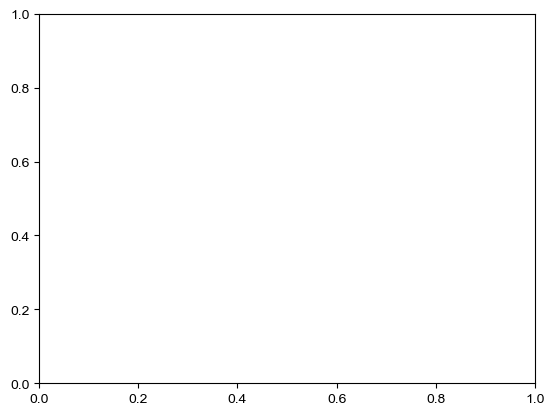

In [ ]:
fig, ax = plt.subplots()

#Replace the paths with the path to models you trained to plot their performance.
paths = [
    'data/local/experiments/tonic/swimmer-swim/pretrained_ncap_ppo',
    'data/local/experiments/tonic/swimmer-swim/pretrained_mlp_ppo'
]
plot_performance(paths, ax=ax, title='MLP v/s NCAP')
plt.tight_layout()
plt.show()

❓



* ***Compare the performance and learning curve of NCAP to MLP for the basic swimmer agent.***
* ***Try testing the model on a modification of the environment (e.g., the 12-link swimmer) it was trained on.***
* ***What happens if we remove certain weight constraints (e.g., sign constraint) from the NCAP model?***


In [ ]:
# add your code

####  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_plot_performance")

---
## Section 4: Visualizing the sparse network


Given the importance of architectural choices in our project we have provided a function which can visualize the network architecture. This includes the ability to render the NCAP network, representing the C. Elegans connectome.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def draw_network(mode='NCAP', N=2, include_speed_control=False, include_turn_control=False):

    """
    Draws a network graph for a swimmer model based on either NCAP or MLP architecture.

    Parameters:
    - mode (str): Determines the architecture type ('NCAP' or 'MLP'). Defaults to 'NCAP'.
    - N (int): Number of joints in the swimmer model. Defaults to 2.
    - include_speed_control (bool): If True, includes nodes for speed control in the graph.
    - include_turn_control (bool): If True, includes nodes for turn control in the graph.
    """


    G = nx.DiGraph()

    n=2+N*4

    nodes =dict()

    if include_speed_control:
      nodes['1-s'] = n+7
    if include_turn_control:
      nodes['r'] = n+5
      nodes['l'] = n+3

    nodes['o'] = n-1
    nodes['$o^d$'] = n-0
    nodes['$o^v$']= n-2

    custom_node_positions = {}
    custom_node_positions['o'] = (1, nodes['o'])
    custom_node_positions['$o^d$'] = (1.5, nodes['$o^d$'])
    custom_node_positions['$o^v$'] = (1.5, nodes['$o^v$'])


    if include_speed_control:
      custom_node_positions['1-s'] = (1.5, nodes['1-s'])
    if include_turn_control:
      custom_node_positions['r'] = (1.5, nodes['r'])
      custom_node_positions['l'] = (1.5, nodes['l'])

    for i in range(1,N+1):
      nodes[f'$q_{i}$'] = 4*(N-i) + 1
      nodes[f'$q^d_{i}$'] = 4*(N-i) + 2
      nodes[f'$q^v_{i}$'] = 4*(N-i)
      nodes[f'$b^d_{i}$'] = 4*(N-i) + 2
      nodes[f'$b^v_{i}$'] = 4*(N-i)
      nodes[f'$m^d_{i}$'] = 4*(N-i) + 2
      nodes[f'$m^v_{i}$'] = 4*(N-i)
      nodes['$\overset{..}{q}$' + f'$_{i}$'] = 4*(N-i) + 1

      custom_node_positions[f'$q_{i}$'] = (1, nodes[f'$q_{i}$'])
      custom_node_positions[f'$q^d_{i}$'] = (1.5, nodes[f'$q^d_{i}$'])
      custom_node_positions[f'$q^v_{i}$'] = (1.5, nodes[f'$q^v_{i}$'])
      custom_node_positions[f'$b^d_{i}$'] = (2, nodes[f'$b^d_{i}$'])
      custom_node_positions[f'$b^v_{i}$'] = (2, nodes[f'$b^v_{i}$'])
      custom_node_positions[f'$m^d_{i}$'] = (2.5, nodes[f'$m^d_{i}$'])
      custom_node_positions[f'$m^v_{i}$'] = (2.5, nodes[f'$m^v_{i}$'])
      custom_node_positions['$\overset{..}{q}$' + f'$_{i}$'] = (3, nodes['$\overset{..}{q}$' + f'$_{i}$'])

    for node, layer in nodes.items():
        G.add_node(node, layer=layer)

    if mode=='NCAP':
        # Add edges between nodes
        edges_colors = ['green', 'orange', 'green', 'green']
        edge_labels = {
            ('o', '$o^d$'):'+1',
            ('o', '$o^v$'):'-1',
            ('$o^d$', '$b^d_1$'):'o',
            ('$o^v$', '$b^v_1$'):'o'
            }

        if include_speed_control:
          edges_colors += ['orange']
          edge_labels[('1-s', '$b^d_1$')] = 's, to all b'
        if include_turn_control:
          edges_colors += ['green', 'green']
          edge_labels[('r', '$b^d_1$')] = 't'
          edge_labels[('l', '$b^v_1$')] = 't'


        for i in range(1,N+1):
          if i < N:
            edges_colors += ['green', 'orange', 'green', 'green']

            edge_labels[((f'$q_{i}$', f'$q^d_{i}$'))] = '+1'
            edge_labels[((f'$q_{i}$', f'$q^v_{i}$'))] = '-1'
            edge_labels[((f'$q^d_{i}$', f'$b^d_{i+1}$'))] = 'p'
            edge_labels[((f'$q^v_{i}$', f'$b^v_{i+1}$'))] = 'p'

          edges_colors += ['green', 'orange', 'green', 'orange',
                          'orange', 'green']

          edge_labels[((f'$b^d_{i}$', f'$m^d_{i}$'))] = 'i'
          edge_labels[((f'$b^d_{i}$', f'$m^v_{i}$'))] = 'c'
          edge_labels[((f'$b^v_{i}$', f'$m^v_{i}$'))] = 'i'
          edge_labels[((f'$b^v_{i}$', f'$m^d_{i}$'))] = 'c'
          edge_labels[((f'$m^v_{i}$', '$\overset{..}{q}$' + f'$_{i}$'))] = '-1'
          edge_labels[((f'$m^d_{i}$', '$\overset{..}{q}$' + f'$_{i}$'))] = '+1'

        edges = edge_labels.keys()

    elif mode=='MLP':
      edges = []
      layers = [1, 1.5, 2, 2.5, 3]
      layers_nodes = [[], [], [], [], []]
      for key, value in custom_node_positions.items():
        ind = layers.index(value[0])
        layers_nodes[ind].append(key)
      for layer_ind in range(len(layers_nodes) - 1):
        for node1 in layers_nodes[layer_ind]:
          for node2 in layers_nodes[layer_ind+1]:
            edges.append((node1, node2))
      edges_colors = np.repeat('gray', len(edges))


    G.add_edges_from(edges)

    # Draw the graph using the custom node positions
    options = {"edge_color": edges_colors, "edgecolors": "tab:gray", "node_size": 500, 'node_color':'white'}
    nx.draw(G, pos=custom_node_positions, with_labels=True, arrowstyle="-", arrowsize=20, **options)
    if mode=='NCAP':
      nx.draw_networkx_edge_labels(G, pos=custom_node_positions, edge_labels=edge_labels)

In [ ]:
draw_network('MLP', N=6)

In [ ]:
draw_network('NCAP', N=6, include_speed_control=True, include_turn_control=True)

Notice that the NCAP architecture is highly sparse and interpretable as compared to the MLP. Moreover notice that the ncap architecture can be completely embedded within a fully connected MLP of 3 hidden layers and ReLU nonlinearities. This enables us to do a thorough investigation into how specific architectural elements influence both performance and the learning process. By leveraging this capability, we can systematically analyze the impact of the architectural preferences inherent to the model and make better design choices.



*It might be useful to also visualize the network's activity for NCAP. Given it only has 4 learnable parameters it becomes much easier to interpret the network.*



###  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_visualizing_the_sparse_network")

---
## Conclusion



Based on the concepts we've discussed in this tutorial, you should now be equipped to advance with the project. Within this project, there are multiple pathways you can explore. For each pathway, you will delve deeply into one of the main sections outlined in this notebook, allowing for a thorough investigation of different factors that can influence performance:

*   ***Exploring the effects of environment:*** Investigate how different environmental settings impact agent performance. This could involve altering parameters of the environment or the types of tasks and reward functions. Understanding these effects can help in making better architectural choices and learning algorithms that result in agents that are robust and adaptable


*   ***Exploring the effects of learning algorithms:*** Standard RL algorithms often struggle with sparse and constrained networks, which can lead to suboptimal performance. Explore where these algorithms fail and analyze potential reasons for their limitations. Experiment with modifications or alternative algorithms that might overcome these challenges.


* ***Exploring the effects of model architecture:*** Investigate how various architectural decisions within the NCAP model influence its performance. Visualize the model and its activity and explore potential improvements by tweaking architectural elements, assessing how these changes affect learning outcomes and operational efficiency.